In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import numba 

import pickle
from pcygni_5 import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d
import lmfit
import time

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    
def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.warn("IntegrationWarning", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [3]:
OB = 'OB1'

In [4]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[0]).T
#x= np.array([wl, flux, error,error]).T
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 3600) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,2][exc_reg_2]

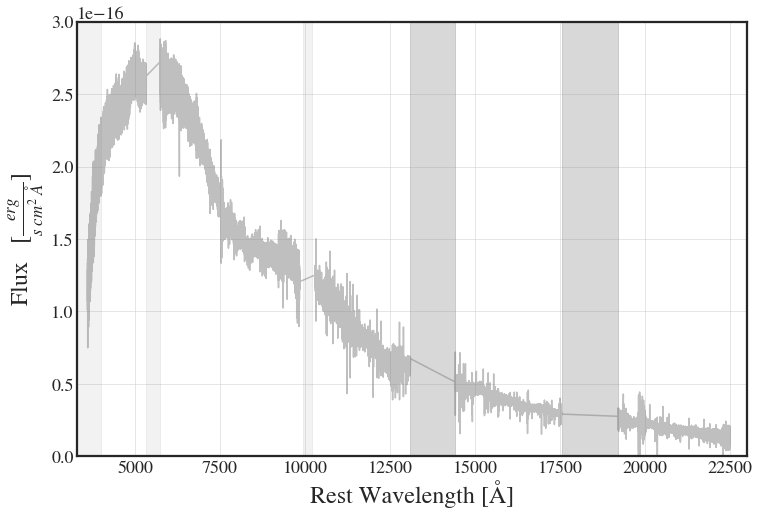

In [5]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(wl, flux, label='X-shooter spectra', color='grey', alpha=0.5)

#plt.plot(wl,flux_fit, ls='--', color='k', label='Blackbody-fit')
#plt.fill_between(x[:,0], x[:,1]-x[:,2], x[:,1]+x[:,2], 
#                 color='grey', alpha=0.9)
plt.ylim(0, 3e-16), plt.xlim(3300, 23000)

#define telluric region
ax.fill_between([13100, 14400], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )
ax.fill_between([17550, 19200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.3 )

#poorly constrained regions
ax.fill_between([5330, 5740], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1   )
ax.fill_between([9940, 10200], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

#define absorbtion feature
#ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
ax.fill_between([3000, 4000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )

plt.xlabel('Rest Wavelength [Å]'), plt.ylabel(r'Flux   $ [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
ax.ticklabel_format(axis='x', style='plain')
#plt.xlim(9000,12000)
#plt.xscale('log') 
#plt.savefig('Pictures/Second_epoch_OB1_emcee_no_gaussian.png', dpi=300)

In [6]:
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    #def integral(x): 
    #    return np.sqrt(1-v**2) * 1/(1+v*np.cos(x))*np.sin(x)*np.cos(x)**2 * (3) 

    #corr = np.zeros_like(vphot)
    #for i,v in enumerate(vphot):
    #    delta = quad(integral, 0, np.pi/2)[0]
    #    corr[i] = delta**4
    delta = 1-2/3*11/10*vphot
    corr = delta**4
    
    theta = 2*np.sqrt(corr*N*10**(7))

    v = vphot*c #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23)
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]

In [7]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

#### Fit structure

In [9]:
p = lmfit.Parameters()
OB = 'OB1'
with open("./data/%s_init.json"%OB, 'r') as infile:
    p.load(infile)

start = time.time()
#mi2 = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))
end = time.time()
print('Time elapsed:',(end-start)/60) 

Time elapsed: 0.7906197547912598


In [8]:
pickle_in = open("./data/OB1/OB1_3_peaks_XL_3.pkl","rb")
emcee_res = pickle.load(pickle_in)
p = emcee_res.params
print(lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot'])
p['sig1'].vary=False; p['sig2'].vary=False; 
p['amp1'].vary=False; p['amp2'].vary=False; 

p

39.77960389774429 <Parameter 've', value=0.26456568130047664 +/- 0.036, bounds=[0:1]> <Parameter 'vphot', value=0.2826111812001722 +/- 0.000325, bounds=[0:1]>


name,value,standard error,relative error,initial value,min,max,vary
T,5449.13210,1.27104706,(0.02%),5447.667793298019,2500.00000,7500.00000,True
N,1.3228e-29,1.3720e-32,(0.10%),1.323796510482438e-29,-inf,inf,True
vphot,0.28261118,3.2492e-04,(0.11%),0.27748049315364803,0.00000000,1.00000000,True
vmax,0.33902586,3.8623e-04,(0.11%),0.33866506716242817,0.00000000,1.00000000,True
t0,126000.000,,(0.11%),126000,-inf,inf,False
tau,2.15729048,0.47942493,(22.22%),2.226553928678608,0.00000000,100.000000,True
vref,0.00000000,,(22.22%),0.0,0.00000000,1.00000000,False
ve,0.26456568,0.03603613,(13.62%),0.22889163223768488,0.00000000,1.00000000,True
occult,0.00770568,0.00512084,(66.46%),0.0035476731178831224,0.00000000,2.00000000,True
amp1,0.23213462,0.00367977,(1.59%),0.2567428720093393,0.01000000,5.00000000,False


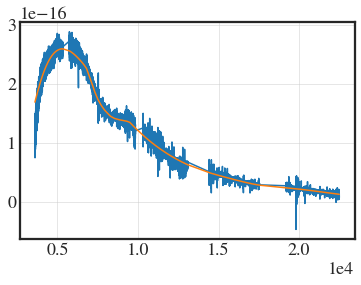

In [10]:
plt.plot(wl, flux )
plt.plot(wl, residual(emcee_res.params, wl*1e-10) )

res = flux - residual(emcee_res.params, wl*1e-10)
#flux_rev = flux + res #*4
#error_rev = error*2
#plt.plot(wl, flux_rev, alpha=0.2 )

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error)

In [12]:
np.shape(res)

(44993,)

In [19]:
width = 500
typical_res = []
typical_res_mean = []
for i in wl:
    typical_res_mean.append(np.mean(res[(wl<(i+width)) & (wl>(i-width))]))
    typical_res.append(np.std(res[(wl<(i+width)) & (wl>(i-width))]))

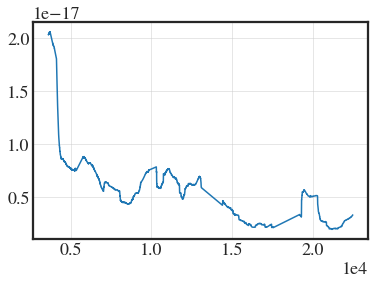

In [18]:
plt.plot(wl, typical_res)

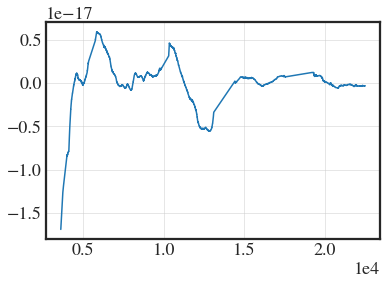

In [21]:
plt.plot(wl, typical_res_mean)

(-0.01, 0.1)

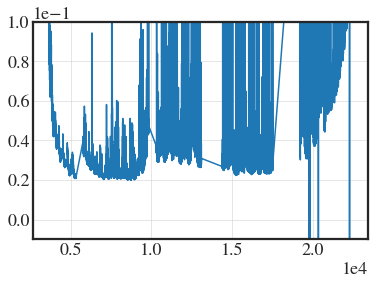

In [140]:
plt.plot(wl, error/flux)
plt.ylim(-1e-2, 1e-1)

In [22]:
np.mean(typical_res)

6.619502709956308e-18

In [50]:
np.std(res)

8.837757377228122e-18

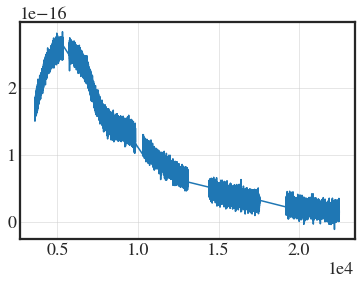

In [25]:


plt.plot(wl, gen+scatter)

#### Markov Chain Monto Carlo to sample distribution




In [175]:
burn_in = 200
total   = 4200 
nwalkers = 25

In [176]:
scatter = np.random.normal(loc=0.0, scale=6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res1 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [42:34<00:00,  1.64it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [263.32794322 280.06078697 258.50716099 259.51295243 390.79399301
 396.09672858 370.36307748]
Time elapsed [hours]: 0.7099232740534677


In [177]:
##2 uncertainty
scatter = np.random.normal(loc=0.0, scale=2*6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 2*6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res2 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [42:37<00:00,  1.64it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [211.70382589 210.70483249 184.92487109 238.79492715 454.38495202
 457.11462164 231.88616818]
Time elapsed [hours]: 0.7107355884710949


In [178]:
## 3 times uncertainty
scatter = np.random.normal(loc=0.0, scale=3*6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 3*6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res3 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [42:22<00:00,  1.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [209.03666936 211.29626595 195.44769726 250.18692138 437.41460666
 444.91663355 222.73866429]
Time elapsed [hours]: 0.706629273560312


In [179]:
## 4 Times Uncertainty
scatter = np.random.normal(loc=0.0, scale=4*6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 4*6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res4 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [41:27<00:00,  1.69it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [178.65809994 178.27768453 198.56612213 253.38448362 433.29338364
 444.28112375 202.27094575]
Time elapsed [hours]: 0.6913062668508954


In [180]:
## 5 times uncertainty
scatter = np.random.normal(loc=0.0, scale=5*6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 5*6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res5 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [39:32<00:00,  1.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [178.68249301 187.79663234 198.95004792 221.97492433 445.25374941
 429.45843489 222.16417292]
Time elapsed [hours]: 0.6593047038051817


In [181]:
## 6 times uncertainty
scatter = np.random.normal(loc=0.0, scale=6*6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 6*6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res6 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [40:13<00:00,  1.74it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [194.73509314 198.05184151 196.37192269 210.12428983 466.45676219
 470.66171861 236.76150282]
Time elapsed [hours]: 0.6705430362621942


In [182]:
## 7 times uncertainty
scatter = np.random.normal(loc=0.0, scale=7*6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 7*6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res7 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [39:53<00:00,  1.75it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [215.93524555 219.02671179 201.14605368 168.46981476 435.14731012
 454.14409389 217.44035357]
Time elapsed [hours]: 0.6650679977734885


In [183]:
## 8 times uncertainty
scatter = np.random.normal(loc=0.0, scale=8*6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 8*6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res8 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [40:00<00:00,  1.75it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [195.6452239  187.67426339 198.78249462 243.60542555 379.07364092
 375.68721853 234.8771743 ]
Time elapsed [hours]: 0.6670004273785485


In [184]:
## 9 times uncertainty
scatter = np.random.normal(loc=0.0, scale=9*6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 9*6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res9 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [40:36<00:00,  1.72it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [295.85533855 302.19938688 233.66377457 179.27094974 382.84330612
 352.17194273 354.67967561]
Time elapsed [hours]: 0.6771554558144676


In [185]:
## 10 times uncertainty
scatter = np.random.normal(loc=0.0, scale=10*6.6e-18, size=len(wl))
gen = residual(emcee_res.params, wl*1e-10)

flux_rev = gen + scatter  #*4
error_rev = 10*6.6e-18*np.ones_like(flux_rev)

def lnprob2(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual(pars, wl*1e-10)
    return lnprob_inner(model, flux_rev, error_rev)

mini = lmfit.Minimizer(lnprob2, p) 

start = time.time()
res10 = mini.emcee(nwalkers=nwalkers, burn=burn_in, steps=total, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )

#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

100%|██████████| 4200/4200 [42:12<00:00,  1.66it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 84;
tau: [260.69702196 253.83589653 207.43138052 296.00138853 435.9547821
 443.48780163 294.95048107]
Time elapsed [hours]: 0.7036776005559496


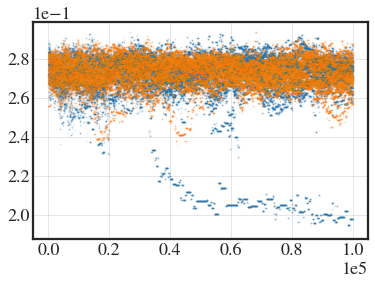

In [197]:
plt.scatter(np.arange(len(res10.flatchain['vphot'])), res10.flatchain['vphot'], s=0.5, alpha=0.1)
plt.scatter(np.arange(len(res10.flatchain['vphot'])), res8.flatchain['vphot'], s=0.5, alpha=0.1)


In [164]:
np.std(lum_dist_arr( res5.flatchain['N'], res5.flatchain['vphot'], n_days=1.45))

0.5916793089379324

In [210]:
y = [np.std(lum_dist_arr( res1.flatchain['N'], res1.flatchain['vphot'], n_days=1.45)), 
     np.std(lum_dist_arr( res2.flatchain['N'], res2.flatchain['vphot'], n_days=1.45)), 
     np.std(lum_dist_arr( res3.flatchain['N'], res3.flatchain['vphot'], n_days=1.45)), 
     np.std(lum_dist_arr( res4.flatchain['N'], res4.flatchain['vphot'], n_days=1.45)),
     np.std(lum_dist_arr( res5.flatchain['N'], res5.flatchain['vphot'], n_days=1.45)), 
     np.std(lum_dist_arr( res6.flatchain['N'], res6.flatchain['vphot'], n_days=1.45)),
     np.std(lum_dist_arr( res7.flatchain['N'], res7.flatchain['vphot'], n_days=1.45)),
     #np.std(lum_dist_arr( res8.flatchain['N'], res8.flatchain['vphot'], n_days=1.45)),
     np.std(lum_dist_arr( res9.flatchain['N'], res9.flatchain['vphot'], n_days=1.45))] 
     #np.std(lum_dist_arr( res10.flatchain['N'], res10.flatchain['vphot'], n_days=1.45))]
print(y)

#[0.09845269776478048, 0.21797343042992098, 0.29209286277347535, 0.38601029238771206, 0.5916793089379324, 
#0.6041714458282319, 0.7684282305348956, 0.7933170725146867, 0.9241069953877, 1.2989640231835549]


#[0.10326005102162385, 0.1906499024007646, 0.30029560944565364, 0.4012386818602298, 0.4567909733458425, 
#0.5341173495265363, 0.6762038185329766, 1.2247216118026634, 1.0387037145267284, 2.209835762023448]

#y = [np.std(lum_dist_arr( res1.flatchain['N'], re

[0.10326005102162385, 0.1906499024007646, 0.30029560944565364, 0.4012386818602298, 0.4567909733458425, 0.5341173495265363, 0.6762038185329766, 1.0387037145267284]


In [85]:
y = [np.std(lum_dist_arr( res1.flatchain['N'], res1.flatchain['vphot'], n_days=1.45)), 
     np.std(lum_dist_arr( res2.flatchain['N'], res2.flatchain['vphot'], n_days=1.45)), 
     np.std(lum_dist_arr( res4.flatchain['N'], res4.flatchain['vphot'], n_days=1.45)),
     np.std(lum_dist_arr( res6.flatchain['N'], res6.flatchain['vphot'], n_days=1.45)),
     np.std(lum_dist_arr( res8.flatchain['N'], res8.flatchain['vphot'], n_days=1.45)),
     np.std(lum_dist_arr( res10.flatchain['N'], res10.flatchain['vphot'], n_days=1.45))]
print(y)

#[0.09845269776478048, 0.21797343042992098, 0.38601029238771206, 0.6041714458282319, 
#0.7933170725146867, 1.2989640231835549]

[0.09845269776478048, 0.21797343042992098, 0.38601029238771206, 0.6041714458282319, 0.7933170725146867, 1.2989640231835549]


In [135]:
np.polyfit(40*np.sqrt(noise/6.6e-18), y/ (40*np.sqrt(noise/6.6e-18)), 1)

array([ 7.85428170e-05, -9.66273117e-04])

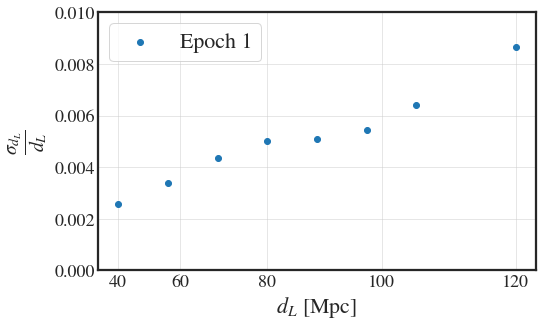

In [215]:
reset_plt(18,22)

fig,ax = plt.subplots(figsize=(8,5))
noise = 6.6e-18*np.array([1,2,3,4,5,6,7,9])

plt.scatter(noise, y/ (40*np.sqrt(noise/6.6e-18)), label='Epoch 1' )

plt.xticks([6.6e-18, 2.25*6.6e-18, 4*6.6e-18, 6.3*6.6e-18, 9*6.6e-18], ['40', '60', '80', '100', '120'])
plt.ylim(0, 0.01), plt.ylabel(r'$\frac{\sigma_{d_L}}{d_L}$', fontsize=28), plt.xlabel(r'$d_L$ [Mpc]')
plt.ticklabel_format(axis="y", style="plain", scilimits=(0,0)), plt.legend(frameon=True);
plt.tight_layout()
#plt.savefig('Pictures/rel_unc_dl.png', dpi=300)

[ 5.67884150e-07 -2.30174992e-05  2.80719559e-03]


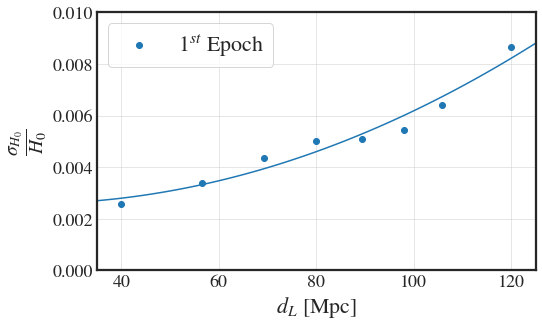

In [224]:
reset_plt(18,22)

fig,ax = plt.subplots(figsize=(8,5))
noise = 6.6e-18*np.array([1,2,3,4,5,6,7,9])#,10])

plt.scatter(40*np.sqrt(noise/6.6e-18), y/ (40*np.sqrt(noise/6.6e-18)), label='$1^{st}$ Epoch' )

#plt.xticks([6.6e-18, 2.25*6.6e-18, 4*6.6e-18, 6.3*6.6e-18, 9*6.6e-18], ['40', '60', '80', '100', '120'])
#plt.ylim(0, 0.01), plt.ylabel(r'$\frac{\sigma_{d_L}}{d_L}$', fontsize=28), plt.xlabel(r'$d_L$ [Mpc]')
plt.ylim(0, 0.01), plt.ylabel(r'$\frac{\sigma_{H_0}}{H_0}$', fontsize=28), plt.xlabel(r'$d_L$ [Mpc]')
plt.ticklabel_format(axis="y", style="plain", scilimits=(0,0)), plt.legend(frameon=True);
plt.tight_layout()

beta = np.polyfit(40*np.sqrt(noise/6.6e-18), y/ (40*np.sqrt(noise/6.6e-18)), 2)
x_0 = np.linspace(30,130,100)
plt.xlim(35, 125)
plt.plot(x_0, x_0**2*beta[0]+x_0*beta[1]+beta[2])
print(beta)
¤plt.savefig('Pictures/rel_unc_dl_4.png', dpi=300)

In [221]:
0.07/40

0.0017500000000000003

In [137]:
, y/ (40*np.sqrt(noise/6.6e-18))

(array([ 40.        ,  56.56854249,  80.        ,  97.97958971,
        113.13708499, 126.49110641]),
 array([0.00246132, 0.00385326, 0.00482513, 0.0061663 , 0.007012  ,
        0.01026921]))

In [25]:
#with open("./Data/OB1/OB1_3_peaks_XL_4.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

In [31]:
2300*50/1000

115.0

In [24]:
#with open("./Data/OB1/OB1_3_peaks_XL_2.pkl", 'wb') as outfile:
#    pickle.dump(res2, outfile) 

##### Plot d_l

In [34]:
pickle_in = open("./data/OB1/OB1_3_peaks_XL.pkl","rb")
res2 = pickle.load(pickle_in)
p = res2.params
lum_dist_arr(p['N'],p['vphot'],n_days=1.43), p['ve'], p['vphot']

(38.813493580011105,
 <Parameter 've', value=0.22889163223768488 +/- 0.0746, bounds=[0:1]>,
 <Parameter 'vphot', value=0.27748049315364803 +/- 0.000622, bounds=[0:1]>)

39.75558139150157 39.74451174664835 39.77039773088996


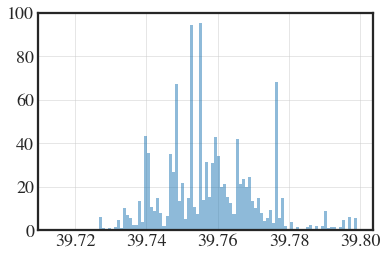

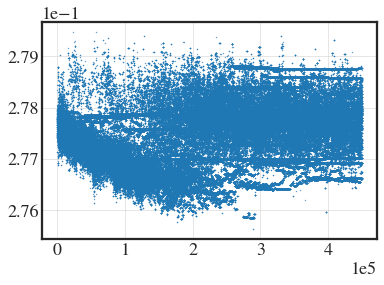

In [36]:
plt.scatter(np.arange(len(flat['vphot'])), flat['vphot'], s = 0.1)


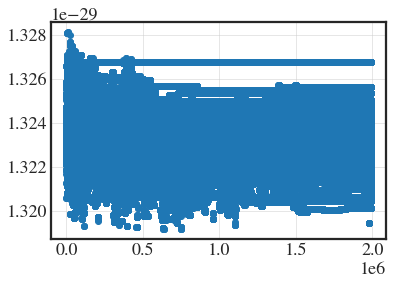

In [28]:
plt.scatter(np.arange(len(flat['vphot'][10000:])), flat['N'][10000:])


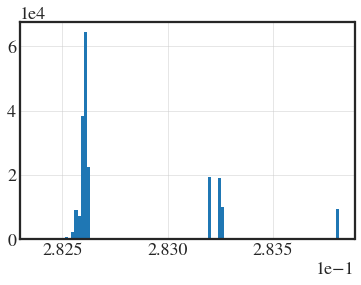

In [18]:
plt.hist(flat['vphot'][10000:], bins=100); 

In [199]:
0.00980*c*1e-3/45.7, 0.00980*c*1e-3/46.1

(64.33260393873086, 63.77440347071583)

In [38]:
import corner

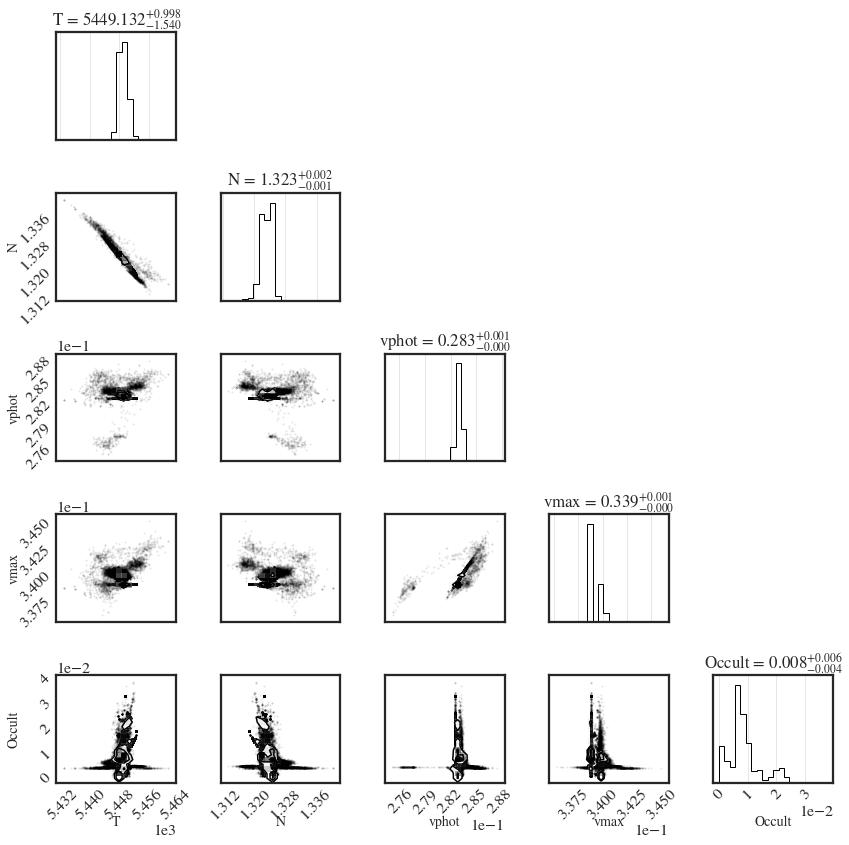

In [50]:
fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult']]).T, 
            labels=['T', 'N', 'vphot','vmax', 'Occult'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

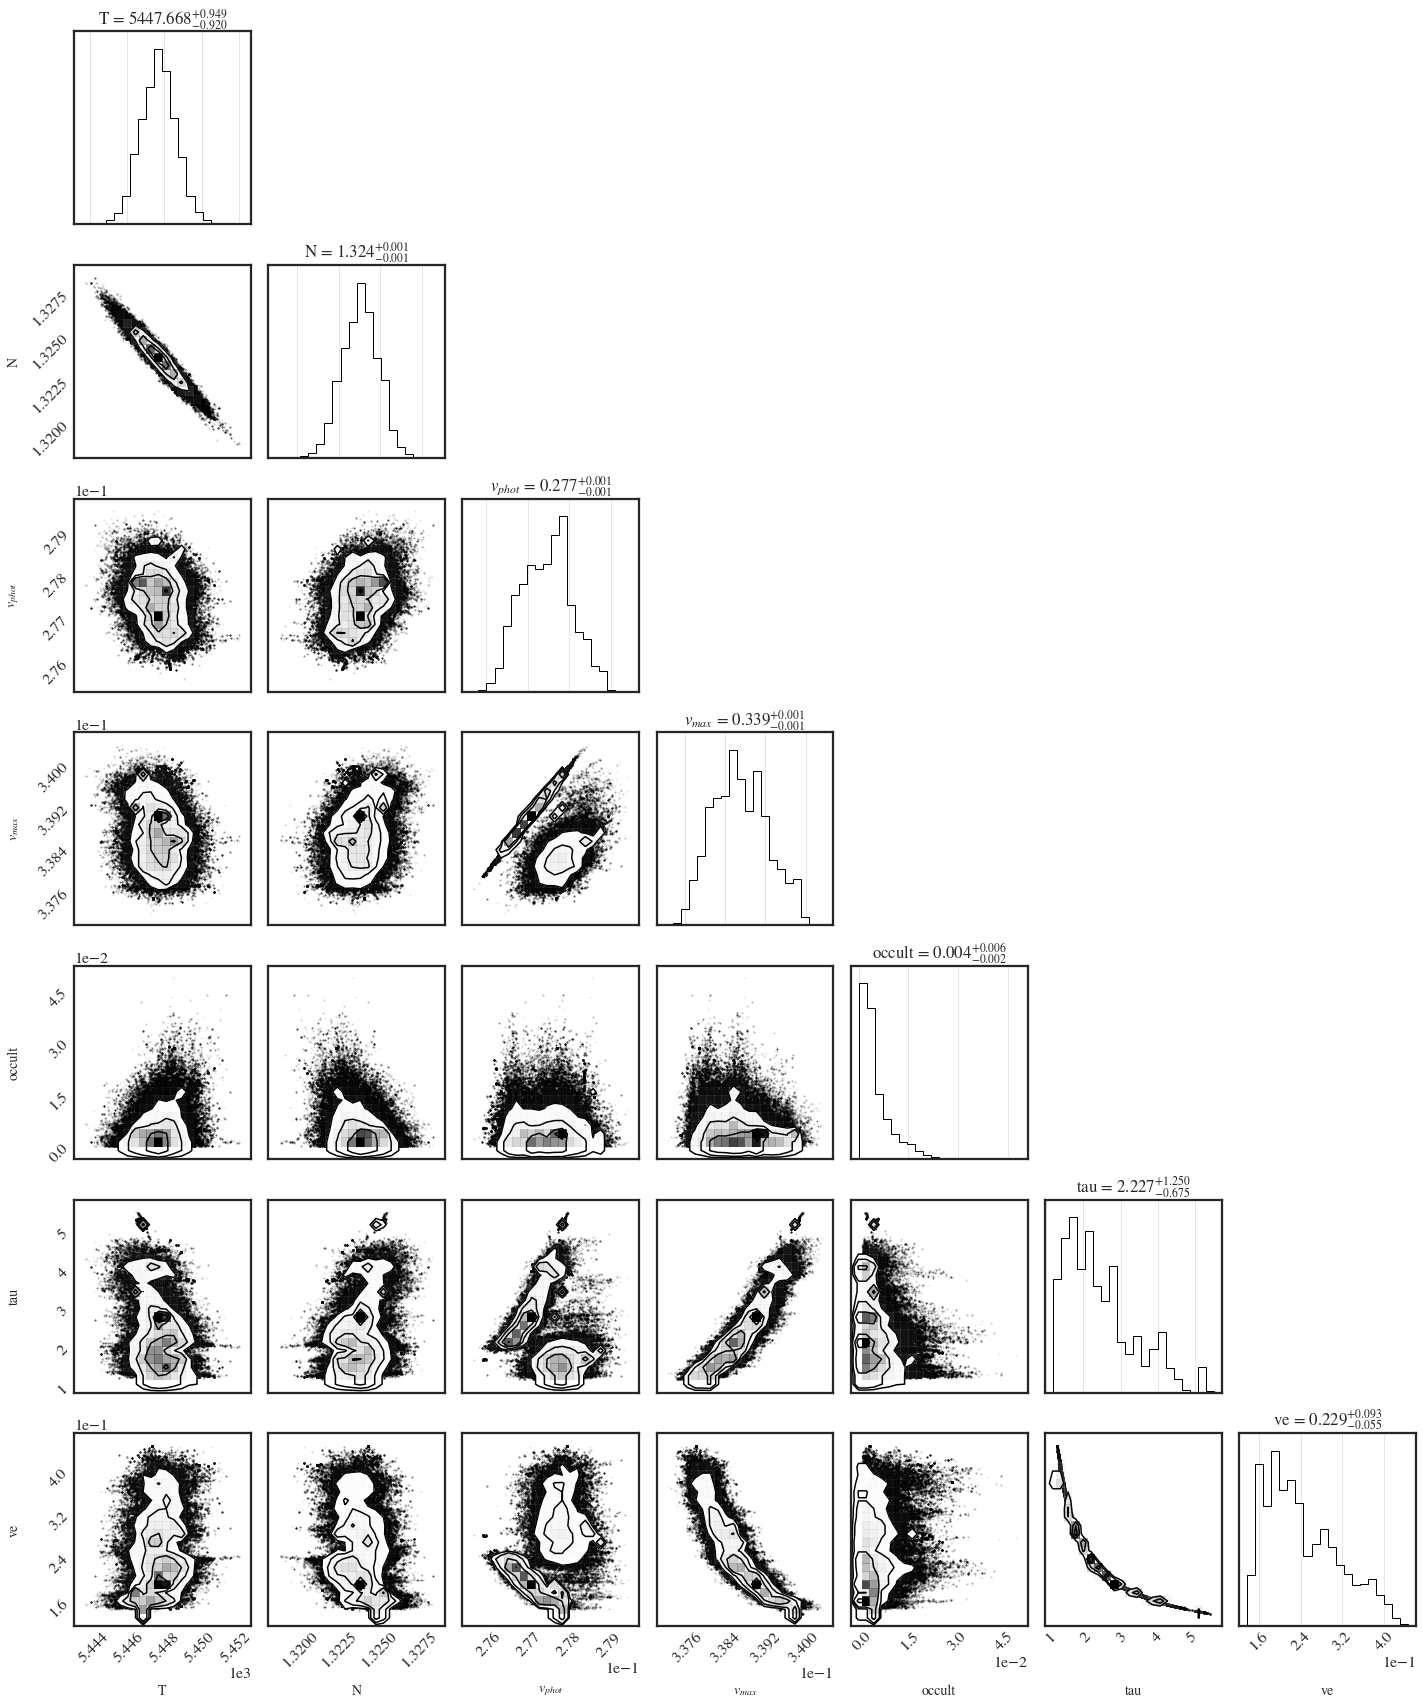

In [83]:
n_box = 7
fig,ax = plt.subplots(figsize=(20,24),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax'], flat['occult'], flat['tau'], flat['ve']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$','occult','tau','ve'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

plt.savefig('Pictures/OB1_covariance_large.png', dpi=300)

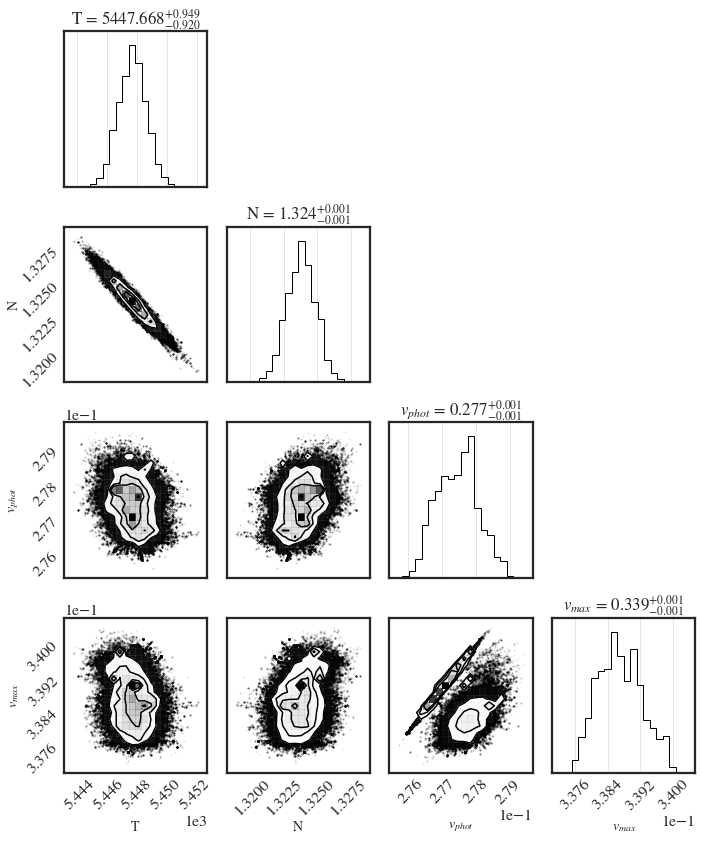

In [39]:
n_box = 4
fig,ax = plt.subplots(figsize=(10,12),nrows=n_box,ncols=n_box)
#ax = ax.flatten()
reset_plt(16, 14)
corner.corner( np.array([flat['T'], flat['N']*1e29, flat['vphot'], flat['vmax']]).T, 
              labels=['T', 'N', r'$v_{phot}$', r'$v_{max}$'], 
              show_titles=True, fig=fig, title_fmt = '.3f'); 
plt.tight_layout() 

#plt.savefig('Pictures/OB1_covariance_small.png', dpi=300)

In [60]:
## day 1
1+(23-12)/24+(21-41)/24/60

#23:45:35
#23:34:00
#23:22:22
#23:57:12
        
dtime1 = 1 + (23-12)/24 + (np.mean([16])-41)/(24*60)
dtime1

1.440972222222222

In [61]:
## day 2
2+(23-12)/24+(28-41)/24/60

# 23:53:42
# 23:58:38
# 23:38:35
# 23:28:45

dtime2 = 2 + (23-12)/24 + (np.mean([23])-41)/(24*60)
dtime2

2.4458333333333333

In [54]:
3+(24-12)/24+(5-41)/24/60

#  23:25:24
#  23:37:01
#  23:48:40
#  00:23:28
#  00:11

dtime3 = 3 + (23-12)/24 + (np.mean([25, 37, 48, 23+60, 11+60])-41)/(24*60)
dtime3

3.466527777777778

In [58]:
30/24/60

0.020833333333333332

In [62]:
3+(24-12)/24+(5-41)/24/60

#  23:50
#  23:25
#  23:30
#  23:35

dtime4 = 4 + (23-12)/24 + (np.mean([13])-41)/(24*60)
dtime4

4.438888888888888

In [31]:
## day 4
4+(23-12)/24+(50-41)/24/60

4.464583333333333

In [40]:
30/24/60

0.020833333333333332